In [1]:
%pip install gdown
import gdown
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
from sklearn.model_selection import train_test_split, KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import Subset
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt

url = "https://drive.google.com/drive/folders/1gq7XBf4MKWi2JpCHdfjiPXzu8Db2p31n?usp=sharing"
gdown.download_folder(url, quiet=True)

['/content/Dataset/test.csv',
 '/content/Dataset/train.csv',
 '/content/Dataset/training.csv']

**PREPROCESSING OF THE DATA**

In [9]:
X = pd.read_csv("Dataset/train.csv", sep=';')
y = X['Crime_Category']
X = X.drop('Crime_Category', axis=1)

# Delete useless column
X.drop('Cross_Street', axis=1, inplace=True)

# Uknown values management
X['Victim_Sex'] = X['Victim_Sex'].replace(['H', 'X'], 'Unknown')
X['Victim_Descent'] = X['Victim_Descent'].fillna('Unknown')
X['Weapon_Description'] = X['Weapon_Description'].fillna('No Weapon')
X['Weapon_Used_Code'] = X['Weapon_Used_Code'].fillna(0)
X['Modus_Operandi'] = X['Modus_Operandi'].fillna('Unknown')

# Date management
X['Date_Reported'] = pd.to_datetime(X['Date_Reported'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')
X['Date_Occurred'] = pd.to_datetime(X['Date_Occurred'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')
X['Year_Reported'] = X.Date_Reported.dt.year
X['Year_Occurred'] = X.Date_Occurred.dt.year
X['Month_Reported'] = X.Date_Reported.dt.month
X['Month_Occurred'] = X.Date_Occurred.dt.month
X['Day_Reported'] = X.Date_Reported.dt.day
X['Day_Occurred'] = X.Date_Occurred.dt.day
X.drop(['Date_Reported', 'Date_Occurred'], axis=1, inplace=True)

# Split of the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Encoding categorical columns with handling for unseen values
categorical_columns = ['Location', 'Area_Name', 'Modus_Operandi', 'Victim_Sex', 'Victim_Descent',
                       'Premise_Description', 'Weapon_Description', 'Status', 'Status_Description']

for col in categorical_columns:
    # Create a unique mapping of values for the training set
    unique_vals = X_train[col].astype(str).unique()
    mapping = {val: idx for idx, val in enumerate(unique_vals)}

    # Apply the mapping to the training set
    X_train[col] = X_train[col].astype(str).map(mapping)

    # Apply the mapping to the test set, handling unseen values
    X_test[col] = X_test[col].astype(str).map(mapping).fillna(-1).astype(int)

# Split of the training set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

if y_train.dtype == 'object':
    y_train = y_train.astype('category').cat.codes
if y_val.dtype == 'object':
    y_val = y_val.astype('category').cat.codes
if y_test.dtype == 'object':
    y_test = y_test.astype('category').cat.codes

# Tensors PyTorch
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

**TRAINING OF A NEURAL NETWORK MODEL**

In [16]:
# 1. Model definition
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)  # First Layer
        self.dropout = nn.Dropout(0.3)  # Dropout
        self.fc2 = nn.Linear(64, 32)  # Second Layer
        self.fc3 = nn.Linear(32, output_size)  # Output Layer
        self.l2_regularizer = 0.001  # L2 Regularization (Weight Decay)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x

# 2. Model's parameters
input_size = X_train.shape[1]
output_size = len(y.unique())
learning_rate = 0.001

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NeuralNetwork(input_size, output_size)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay = model.l2_regularizer)
criterion = nn.CrossEntropyLoss()

# 3. Training and Validation step
epochs = 10

# Training e Validation loop
# early stopping
patience = 3
counter = 0
best_val_loss = float('inf')

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch")
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        progress_bar.set_postfix(loss=running_loss/len(train_loader))

    # Validazione
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {running_loss/len(train_loader):.4f}, Validation Loss: {val_loss/len(val_loader):.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        counter = 0
    else:
        counter += 1

    if counter >= patience:
        print("Early stopping")
        break

Epoch 1/10: 100%|██████████| 400/400 [00:02<00:00, 166.58batch/s, loss=1.95]


Epoch 1/10, Training Loss: 1.9453, Validation Loss: 2.0292


Epoch 2/10: 100%|██████████| 400/400 [00:02<00:00, 176.73batch/s, loss=1.87]


Epoch 2/10, Training Loss: 1.8735, Validation Loss: 1.8011


Epoch 3/10: 100%|██████████| 400/400 [00:02<00:00, 174.09batch/s, loss=1.81]


Epoch 3/10, Training Loss: 1.8091, Validation Loss: 1.8011


Epoch 4/10: 100%|██████████| 400/400 [00:01<00:00, 200.61batch/s, loss=1.81]


Epoch 4/10, Training Loss: 1.8091, Validation Loss: 1.8011


Epoch 5/10: 100%|██████████| 400/400 [00:02<00:00, 198.48batch/s, loss=1.81]


Epoch 5/10, Training Loss: 1.8091, Validation Loss: 1.8011
Early stopping


**EVALUATION**

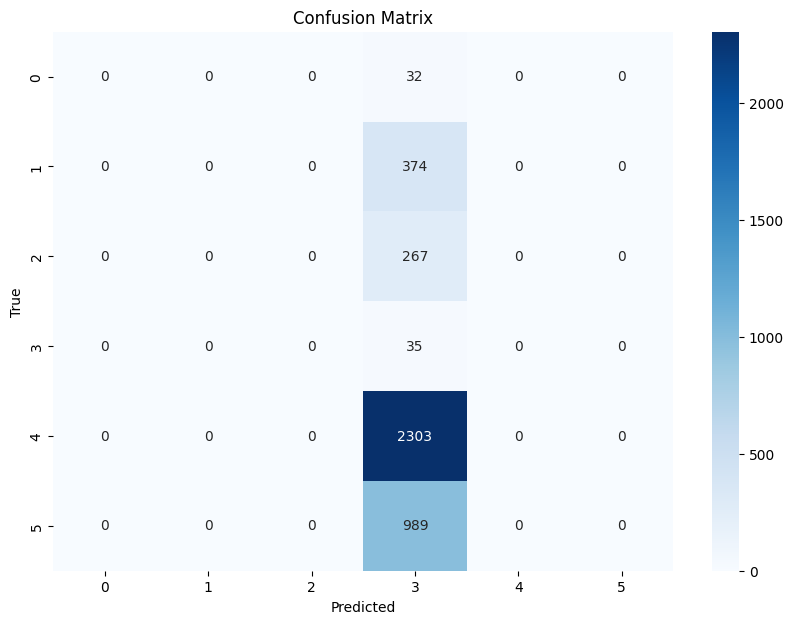

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        32
           1       0.00      0.00      0.00       374
           2       0.00      0.00      0.00       267
           3       0.01      1.00      0.02        35
           4       0.00      0.00      0.00      2303
           5       0.00      0.00      0.00       989

    accuracy                           0.01      4000
   macro avg       0.00      0.17      0.00      4000
weighted avg       0.00      0.01      0.00      4000



In [11]:
# 5. Evaluation
model.eval()
correct = 0
total = 0
y_pred = []
y_true = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

accuracy = 100 * correct / total

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
class_report = classification_report(y_true, y_pred, zero_division=0)
print("Classification Report:")
print(class_report)